In [1]:
from google.colab import drive, output
drive.mount('/content/drive')
import sys
%cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
%load_ext autoreload
%autoreload 1
!pip install torchaudio
!pip install wandb --upgrade
!wandb login
output.clear()

In [2]:
# from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
# import IPython

from six.moves import xrange

import datetime
import gc

from scipy import signal

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import ConvAE as AE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018'


dataset = SoundscapeData(root_path, audio_length=12, ext="wav", win_length=1028)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.2), len(dataset) - round(len(dataset)*0.2)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 8,
    "num_epochs": 6,
    "num_hiddens" : 32,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-2,
    "dataset" : "Audios Jaguas",
    "architecture": "AE",
    "win_length" : dataset.win_length
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])


model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 2, gamma = 0.1 )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

In [4]:
from scipy.io.wavfile import write

class TestModel:

    def __init__(self, model, iterator, num_views):
        self._model = model
        self._iterator = iterator
        self.num_views = num_views

    def plot_waveform(self, waveform, n_rows=2, directory=None):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6), constrained_layout=True)
        for i in range(len(waveform)):
            axs[i].plot(waveform[i,0])
            if directory != None:
                scaled = np.int16(waveform[i,0]/np.max(np.abs(waveform[i,0])) * 32767)
                write(directory + str(i) + '.wav', 22050, scaled)
        plt.show()
        
        
    def waveform_generator(self, spec, n_fft=512, win_length=512, audio_length=59, base_win=256, plot=False):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform
    
    def plot_psd(self, waveform):
        for wave in waveform:
            plt.psd(wave)

    def plot_reconstructions(self, imgs_original, imgs_reconstruction, num_views:int = 8):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20,5))
        ax.imshow(img_grid[1,:,:].cpu(), vmin=0, vmax=1)
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _,_) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                    valid_originals.shape[2], valid_originals.shape[3]))
        valid_originals = torch.unsqueeze(valid_originals,1)

        valid_originals = valid_originals.to(device)

        valid_reconstructions = self._model(valid_originals)

        BCE = F.mse_loss(valid_reconstructions, valid_originals)
        loss = BCE

        return valid_originals, valid_reconstructions, loss

    def run(self, plot=True, wave_return=True, wave_plot=True, directory=None):
        wave_original = []
        wave_reconstructions = []
        originals, reconstructions, error = self.reconstruct() 
        if plot:
            self.plot_reconstructions(originals, reconstructions)
        if wave_return:
            wave_original = self.waveform_generator(originals)
            wave_reconstructions = self.waveform_generator(reconstructions)
            if wave_plot:
                self.plot_waveform(wave_original, len(wave_original), directory="originals")
                self.plot_waveform(wave_reconstructions, len(wave_reconstructions), directory="reconstructions")


        return originals, reconstructions, error


class TrainModel:

    def __init__(self, model):
        self._model = model

    def wandb_init(self, config, keys=["audio_length", "win_length", "batch_size"]):
        try:
            run_name = "AE_"
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + ":" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project="AE-Jaguas", config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True         
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})


    def fordward(self, training_loader, test_loader, config):
        iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]

        train_res_recon_error = []
        train_res_perplexity = []
        logs = []
        best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    (data, _,_) = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
                data = torch.unsqueeze(data,1)
                data = data.to(device)

                optimizer.zero_grad()
                data_recon = self._model(data)

                loss = F.mse_loss(data_recon, data)
                loss.backward()

                optimizer.step()
                print(f'epoch: {epoch+1} of {config["num_epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(),4)}')
                dict = {"loss":loss.item()}
                self.wandb_logging(dict)
                                
                
                if (i+1) % 20 == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8)
                        #torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, test_error = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions, 8)
                        images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
                        self.wandb_logging({"examples": images})
                        
                    except Exception as e:
                        print("error")
                        logs.append(e)
                        continue
                else:
                    pass

                if loss < 30:
                    wandb.alert(
                    title='High accuracy',
                    text=f'Recon error {loss} is lower than 0.5',
                    level=AlertLevel.WARN,
                    wait_duration=timedelta(minutes=5)
                                )        
                    torch.save(model.state_dict(),f'{run_name}_low_error.pkl')
                else:
                    pass
            
            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(),f'{time.hour}_{time.minute}_{run_name}_{epoch}.pkl')
            output.clear()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 1 of 502 	 loss: 2679.6958
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 2 of 502 	 loss: 2586.1777
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 3 of 502 	 loss: 2639.6812
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
t

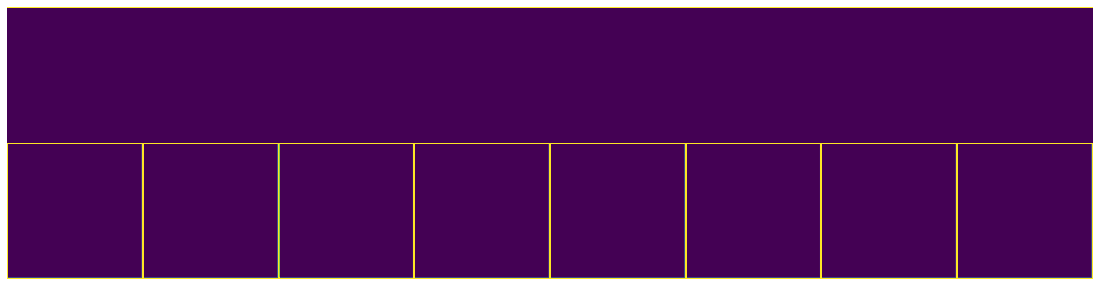

torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 21 of 502 	 loss: 2471.0674
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 22 of 502 	 loss: 2707.5762
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 23 of 502 	 loss: 2771.4131
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515]

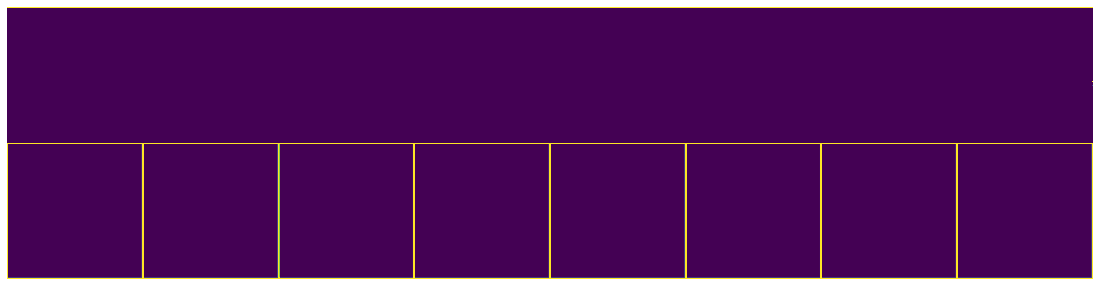

torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 41 of 502 	 loss: 2301.7771
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 42 of 502 	 loss: 2331.6873
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
encoder_shape:  torch.Size([32, 32, 63, 63])
epoch: 1 of 6 	 iteration: 43 of 502 	 loss: 2710.7878
torch.Size([4, 515, 515])
torch.Size([4, 515, 515])
torch.Size([4, 515, 515]

KeyboardInterrupt: ignored

In [5]:
Training = TrainModel(model)
time = datetime.datetime.now()
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
torch.save(model.state_dict(),f'{time.hour}_{time.minute}_{run_name}.pkl')
torch.save(model.state_dict(),f'{run_name}.pkl')